# Handling Imports

In [117]:
import torch
import torch.nn as nn                           #imports the neural network module which contains the nn superclass
import torch.optim as optim                     #imports the optimization algorithms such as gradient descent, adam etc
import torch.nn.functional as F                 #has all the parameter-less functions, imports the activation functions(relu etc), but those can also be found in the nn package
from torch.utils.data import DataLoader         #this provides a dataset class for data representation and a dataloader for iterating over the data among other things.
import torchvision.datasets as datasets         #pytorch comes with datasets which can be imported through this
import torchvision.transforms as transforms     #has methods to perform data augmentation operations such as cropping, resizing, normalization etc.
import wandb
from tqdm import tqdm
import pandas as pd

# Creating a CNN

In [118]:
class CNN(nn.Module):
  def __init__(self,in_channels=1,num_classes=10):                                                                       #constructor method which creates the object of the written class
    super(CNN, self).__init__()                                                                                          #super method which inherits the methods from the parent nn.Module class
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 8, kernel_size=(3,3), stride=(1,1), padding=(1,1))  #same convolution gives the same dimensions of the image as output
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))                                                           #decreases the image dimensions by 2 times
    self.conv1_bn = nn.BatchNorm2d(8) 
    self.drop = nn.Dropout(0.25)
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))           #same convolution 2
    self.conv2_bn = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(16*7*7, num_classes)                                                                            #fully connectetd layer
    # self.fc1_bn = nn.BatchNorm1d(8*7*7)
    # self.fc2 = nn.Linear(8*7*7, num_classes)
    
  def forward(self, x):              #forward-prop method
    x = self.conv1(x)        #relu activation unit after convolution
    x = self.pool1(x)                #max pool layer
    x = F.relu(self.conv1_bn(x))
    x = self.drop(x)
    x = self.conv2(x)
    x = self.pool1(x)                #max pool layer
    x = F.relu(self.conv2_bn(x))     #convolutuion + activation unit 2
    x = self.drop(x)
    x = x.reshape(x.shape[0], -1)    #flatten the output to generate the input for a fully connected layer
    x = self.fc1(x)                  #fully connected layer
    # x = F.relu(self.fc1_bn(x))
    # x = self.fc2(x)
    # x = F.softmax(x, dim = 1)
    return x

# Set Device

In [119]:
 #sets the device to cuda or cpu depending on the avaialability

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# computing the mean, std

In [120]:
def mean_std(loader):
  sum, squared_sum, num_batches = 0,0,0
  for data,_ in loader:
    sum += torch.mean(data,dim=[0,2,3])
    squared_sum += torch.mean(data**2,dim=[0,2,3])
    num_batches += 1
  mean = sum/num_batches
  std = (squared_sum/num_batches - mean**2)**0.5
  return mean, std


# Check Accuracy

In [121]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

# Check if the model has any errors in the structure

In [122]:
model = CNN()

#generates a dummy tensor to check the model parameters
x = torch.randn(64, 1, 28, 28)
print(model(x).shape)

torch.Size([64, 10])


# Hyperparameters

In [123]:
wandb.login()

True

In [124]:
in_channels = 1
batch_size = 64
learning_rate = 10e-4

#output labels
num_classes = 10

#number of epochs the model is training for
num_epochs = 15

In [125]:
# run = wandb.init(
#     # Set the project where this run will be logged
#     project="mnist",
#     # Track hyperparameters and run metadata
#     config={
#         "learning_rate": learning_rate,
#         "epochs": num_epochs;
#     })


# Transformations

In [126]:
train_transforms = transforms.Compose([ transforms.ToTensor() , transforms.Normalize((0.1307), (0.3081))])

# Load Data

In [127]:
#loading the dataset from pytorch

train_dataset = datasets.MNIST(root='dataset/', train=True, transform=train_transforms, download=True) #downloads the MNIST dataset if it isn't already installed
val_dataset = datasets.MNIST(root='dataset/', train=False, transform=train_transforms, download=True)


# Splitting the dataset into train and val set

In [128]:
#splits the dataset of size 60000 into 50k and 10k respectively for the train and val set

# train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
# print(len(train_set))
# print(len(val_set))
print(len(train_dataset))
print(len(val_dataset))

60000
10000


# Initialzing Data Loaders

In [129]:
#initialzing the data loaders for train,val and test sets respectively

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

# mean,std = mean_std(train_loader)
# print(mean)
# print(std)

# Initialize Network

In [130]:
#initializing the model

model = CNN().to(device)

# Loss and Optimizer

In [131]:
#choosing the loss function and optimizing algorithm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network

In [132]:
train_losses = []
train_accuracies = []

def train(epoch):
    train_loss = 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        # get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # so it doesn't store gradients from previous backprops
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        # accumulating loss over an epoch
        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), acc=torch.rand(1).item())

    train_loss = train_loss / len(train_loader)

    # storing the train losses over an epoch in a list
    train_losses.append(train_loss)
    
    train_accuracy = check_accuracy(train_loader, model)
    train_accuracies.append(train_accuracy)

    return train_loss, train_accuracy


# Validation Loss


In [133]:
# calculating the loss for val_set

val_losses = []
val_accuracies = []

def val(epoch):

   val_loss=0

   with torch.no_grad():
     for batch_idx, (data, targets) in enumerate(val_loader): # dividing into batches is possibly unecessary (will check later)

        #get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        #calling the model with the val data and calculating the loss
        scores = model(data)
        
        loss = criterion(scores, targets)
        val_loss += loss.item()              #accumulating val loss over an epoch

   val_accuracy = check_accuracy(val_loader, model)
   val_accuracies.append(val_accuracy)
   
   val_loss = val_loss/len(val_loader)
   val_losses.append(val_loss)  # storing the validation losses over epochs in a list
   
   return val_loss, val_accuracy


# Training the model over epochs


In [134]:
#loops for 20 epochs (will add print statements)

for epoch in range(num_epochs):
    model.train()
    loss_train, acc_train = train(epoch)
    model.eval()
    loss_valid, acc_valid = val(epoch)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))


Epoch [0/15]: 100%|██████████| 938/938 [00:15<00:00, 60.06it/s, acc=0.765, loss=0.0923]  


Epoch: 0  Train Loss: 0.2624  Train Acc: 0.9770  Valid Loss: 0.0793  Valid Acc: 0.9756


Epoch [1/15]: 100%|██████████| 938/938 [00:16<00:00, 58.21it/s, acc=0.879, loss=0.00474] 


Epoch: 1  Train Loss: 0.1103  Train Acc: 0.9824  Valid Loss: 0.0569  Valid Acc: 0.9822


Epoch [2/15]: 100%|██████████| 938/938 [00:14<00:00, 62.89it/s, acc=0.961, loss=0.0741]  


Epoch: 2  Train Loss: 0.0942  Train Acc: 0.9856  Valid Loss: 0.0500  Valid Acc: 0.9830


Epoch [3/15]: 100%|██████████| 938/938 [00:14<00:00, 64.44it/s, acc=0.767, loss=0.00815] 


Epoch: 3  Train Loss: 0.0844  Train Acc: 0.9869  Valid Loss: 0.0448  Valid Acc: 0.9860


Epoch [4/15]: 100%|██████████| 938/938 [00:15<00:00, 60.37it/s, acc=0.329, loss=0.0138]   


Epoch: 4  Train Loss: 0.0797  Train Acc: 0.9885  Valid Loss: 0.0413  Valid Acc: 0.9861


Epoch [5/15]: 100%|██████████| 938/938 [00:15<00:00, 60.54it/s, acc=0.644, loss=0.00403]  


Epoch: 5  Train Loss: 0.0760  Train Acc: 0.9890  Valid Loss: 0.0376  Valid Acc: 0.9870


Epoch [6/15]: 100%|██████████| 938/938 [00:14<00:00, 64.92it/s, acc=0.763, loss=0.0177]   


Epoch: 6  Train Loss: 0.0722  Train Acc: 0.9898  Valid Loss: 0.0366  Valid Acc: 0.9882


Epoch [7/15]: 100%|██████████| 938/938 [00:14<00:00, 65.80it/s, acc=0.694, loss=0.0446]  


Epoch: 7  Train Loss: 0.0693  Train Acc: 0.9908  Valid Loss: 0.0371  Valid Acc: 0.9882


Epoch [8/15]: 100%|██████████| 938/938 [00:14<00:00, 64.67it/s, acc=0.789, loss=0.283]   


Epoch: 8  Train Loss: 0.0692  Train Acc: 0.9905  Valid Loss: 0.0364  Valid Acc: 0.9875


Epoch [9/15]: 100%|██████████| 938/938 [00:15<00:00, 59.87it/s, acc=0.117, loss=0.0257]  


Epoch: 9  Train Loss: 0.0655  Train Acc: 0.9907  Valid Loss: 0.0349  Valid Acc: 0.9889


Epoch [10/15]: 100%|██████████| 938/938 [00:14<00:00, 64.43it/s, acc=0.725, loss=0.12]     


Epoch: 10  Train Loss: 0.0660  Train Acc: 0.9912  Valid Loss: 0.0329  Valid Acc: 0.9895


Epoch [11/15]: 100%|██████████| 938/938 [00:15<00:00, 62.26it/s, acc=0.675, loss=0.00326] 


Epoch: 11  Train Loss: 0.0640  Train Acc: 0.9917  Valid Loss: 0.0330  Valid Acc: 0.9893


Epoch [12/15]: 100%|██████████| 938/938 [00:15<00:00, 61.21it/s, acc=0.168, loss=0.24]     


Epoch: 12  Train Loss: 0.0636  Train Acc: 0.9908  Valid Loss: 0.0334  Valid Acc: 0.9888


Epoch [13/15]: 100%|██████████| 938/938 [00:14<00:00, 64.04it/s, acc=0.861, loss=0.0228]   


Epoch: 13  Train Loss: 0.0612  Train Acc: 0.9916  Valid Loss: 0.0333  Valid Acc: 0.9894


Epoch [14/15]: 100%|██████████| 938/938 [00:15<00:00, 60.24it/s, acc=0.449, loss=0.0235]   


Epoch: 14  Train Loss: 0.0606  Train Acc: 0.9913  Valid Loss: 0.0326  Valid Acc: 0.9895


# Checking the accuracy on training, validation and test sets


In [135]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}") #highest was 99.55
print(f"Accuracy on validation set: {check_accuracy(val_loader, model)*100:.2f}")
# print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}") #highest was 98.69

Accuracy on training set: 99.13
Accuracy on validation set: 98.95


# Plotting the Train Loss and Validation loss vs number of epochs

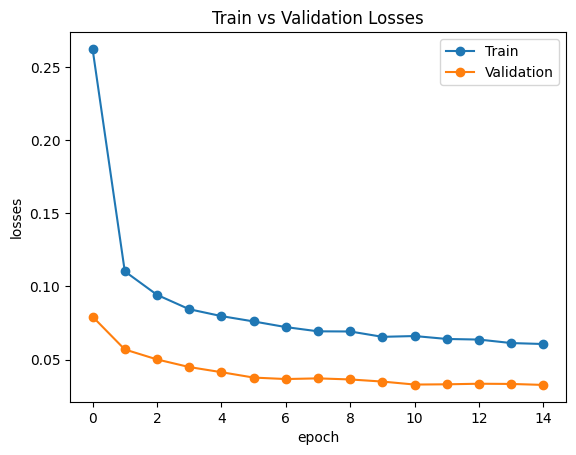

In [136]:
from matplotlib import pyplot as plt

plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation Losses')

plt.show()

In [137]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [138]:
print(count_parameters(model))

9146
